# Heart Disease Classification
Simo Hyttinen<br>
Last edited: 02.02.2018<br>
Cognitive Systems for Health Technology Applications<br>
<a href="https://www.metropolia.fi/en">Helsinki Metropolia University of Applied Sciences</a>


## 1. Objectives
The objective of this assignment is to create a program which can preprocess a dataset and then use that dataset to train a dense neural network to predict whether a person has heart disease or not, based on 13 variables. A major point of learning is to try different configurations of the neural network model, where the hyperparameters change: amount of layers, amount of neurons per layer, epoch amounts and batch sizes and overfitting prevention methods.

## 2. Required libraries

Numpy and matplotlib are imported into the interactive namespace via %pylab. All graphs are to be drawn inline. In addition, pandas, keras, sklearn and timer will be imported.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import keras
import sklearn as sk
from timeit import default_timer as timer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


In [3]:
print('numpy:', np.__version__)
print('pandas:', pd.__version__)
print('sklearn:', sk.__version__)
print('keras:', keras.__version__)

numpy: 1.13.3
pandas: 0.20.3
sklearn: 0.19.1
keras: 2.1.3


## 3. Data description and preprocessing
### 3.1 Importing a processed dataset
The following function imports a preprocessed dataset and sets the column names.

In [4]:
colnames = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs',
                  'restecg', 'thalach', 'exang', 'oldpeak',
                  'slope', 'ca', 'thal', 'num']
datacols = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs',
                  'restecg', 'thalach', 'exang', 'oldpeak',
                  'slope'] # List of column names with 'ca', 'thal' and 'num' omitted for later use
def format_prep_csv(filename):
    df_ret = pd.read_csv(filename, na_values='?')
    df_ret.columns = colnames
    return  df_ret


### 3.2 Importing and processing a raw dataset
This function imports a set of raw data and parses it into intelligible entries.<br><br>
Each entry in the raw dataset is divided into 10 rows with 7-8 columns each (1st row of each entry has no 8th column for some reason). I checked the correct positions of each of the 14 values from the dataset documentation and picked the right values to pull from which row and which column. These are stored in a temporary dataframe. The entries are separated from each other by calculating the modulo 10 of the row index. Depending on the modulus, different actions are taken. From 0-8 values are stored in the temp dataframe. When the modulus is 9, it means the entry is at its end and the temp dataframe is appended to the processed dataframe.

In [5]:
def parse_raw_csv(filename):
    testcols = ["col1", "col2", "col3", "col4", "col5", "col6", "col7", 'col8']
    df_raw = pd.read_csv(filename, sep=' ', names=testcols)
    df_ret = pd.DataFrame(index=[0], columns=colnames)
    df_temp = pd.DataFrame(index=[0], columns=colnames)
    
    for i, row in df_raw.iterrows():
        m = i % 10
        if m == 0:
            df_temp.iloc[0]['age'] = float(row['col3'])
            df_temp.iloc[0]['sex'] = int(row['col4'])
        elif m == 1:
            df_temp.iloc[0]['cp'] = int(row['col2'])
            df_temp.iloc[0]['trestbps'] = float(row['col3'])
            df_temp.iloc[0]['chol'] = float(row['col5'])
        elif m == 2:
            df_temp.iloc[0]['fbs'] = float(row['col1'])
            df_temp.iloc[0]['restecg'] = float(row['col4'])
        elif m == 4:
            df_temp.iloc[0]['thalach'] = float(row['col1'])
            df_temp.iloc[0]['exang'] = float(row['col7'])
        elif m == 5:
            df_temp.iloc[0]['oldpeak'] = float(row['col1'])
            df_temp.iloc[0]['slope'] = float(row['col2'])
            df_temp.iloc[0]['ca'] = float(row['col5'])
        elif m == 6:
             df_temp.iloc[0]['thal'] = float(row['col4'])
        elif m == 7:
            df_temp.iloc[0]['num'] = int(row['col3'])
        elif m == 9:
            for ix in range(len(df_temp.columns)):
                if df_temp.iloc[0][ix] == -9:
                    df_temp.iloc[0][ix] = nan
            df_ret = df_ret.append(df_temp, ignore_index=True)

    df_ret.drop(df_ret.index[0], inplace=True) # Drop the initialization row.
    return df_ret

### 3.3 Compiling the dataset
Here the different datasets are combined into one big dataset. The already preprocessed version of the Cleveland data is used because the raw data file is corrupted. <i>New.data</i> is not used because it seems to have a slightly different formatting compared to the other files.

In [6]:
df_hu = parse_raw_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/hungarian.data")
df_sw = parse_raw_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/switzerland.data")
df_cl = format_prep_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")
df_lbc = parse_raw_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/long-beach-va.data")
df = pd.concat([df_hu, df_sw], ignore_index=True).append(df_cl, ignore_index=True).append(df_lbc, ignore_index=True)
print("Number of entries in the dataset: " + str(len(df.index)))

Number of entries in the dataset: 919


### 3.4 Description of the data
The contains 14 variables that describe the person in the entry:
- Sex ('sex')
- Age ('age')
- Chest pain type ('cp')
    - 1: Typical angina
    - 2: Atypical angina
    - 3: Non-anginal pain
    - 4: Asymptomatic
- Resting blood pressure (mm/Hg) on admission ('trestbps')
- Serum cholesterol (mg/dl) ('chol')
- Fasting blood sugar ('fbs')
    - 1: Over 120mg/dl
    - 0: Under 120mg/dl
- Resting electrocardiographic results ('restecg')
    - 0: Normal
    - 1: ST-T wave abnormality
    - 2: Probable or definite left ventricular hypertrophy
- Maximum heart rate achieved ('thalach')
- Exercise induced angina ('exang')
    - 1: Yes
    - 0: No
- ST depression induced by exercise relative to rest ('oldpeak')
- Slope of the peak exercise ST segment ('slope')
    - 1: Upsloping
    - 2: Flat
    - 3: Downsloping
- Number of major vessels colored by fluoroscopy ('ca')
- thal (?) ('thal')
    - 3: Normal
    - 6: Fixed defect
    - 7: Reversable defect
- Diagnosis of heart disease ('num')
    - 0: No heart disease
    - 1+: Heart disease
    
Some of the values in the data are missing. Missing values, originally distinguished in the raw data with the value -9.0, have been replaced with NaN.

In [7]:
# This is for exporting the combined dataframe as a CSV. I used this to view the data in Excel.

#df.to_csv("data/combined.csv", na_rep = "?")

# Basic data about the dataset

df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,919.0,919,919,860.0,889.0,829.0,917.0,864.0,864.0,857.0,611.0,309.0,442.0,919
unique,50.0,2,4,61.0,217.0,2.0,3.0,119.0,2.0,53.0,4.0,5.0,7.0,5
top,54.0,1,4,120.0,0.0,0.0,0.0,150.0,0.0,0.0,2.0,0.0,3.0,0
freq,51.0,725,496,131.0,172.0,692.0,551.0,42.0,527.0,370.0,345.0,180.0,196.0,410


### 3.5 Dealing with missing values
As we can see from a snippet of 10 of the entries from the beginning of the dataset, there's quite a few missing values there.

In [8]:
# First 10 entries in the dataset

df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,40,1,2,140,289,0,0,172,0,0,NaN,NaN,NaN,0
1,49,0,3,160,180,0,0,156,0,1,2,NaN,NaN,1
2,37,1,2,130,283,0,1,98,0,0,NaN,NaN,NaN,0
3,48,0,4,138,214,0,0,108,1,1.5,2,NaN,NaN,3
4,54,1,3,150,NaN,0,0,122,0,0,NaN,NaN,NaN,0
5,39,1,3,120,339,0,0,170,0,0,NaN,NaN,NaN,0
6,45,0,2,130,237,0,0,170,0,0,NaN,NaN,NaN,0
7,54,1,2,110,208,0,0,142,0,0,NaN,NaN,NaN,0
8,37,1,4,140,207,0,0,130,1,1.5,2,NaN,NaN,1
9,48,0,2,120,284,0,0,120,0,0,NaN,NaN,NaN,0


In [9]:
# The amount of NaN entries per column

df.isnull().sum()

age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       308
ca          610
thal        477
num           0
dtype: int64

As we see, there are 610/919 values missing in the 'ca' column and 477/919 in the 'thal' column. The most sensible thing to do, in my opinion, is to drop those columns since they aren't very useful data with more than half of the values missing.

In [10]:
df_trimmed = df.drop(['ca', 'thal'], axis = 1)

All missing data is replaced with the mean value of its column. An alternative dataset is also created where the rows with missing data are dropped entirely.

In [11]:
df_mean_na = df_trimmed.where(~df_trimmed.isnull(), df_trimmed.mean(), axis = 1)
df_dropna = df_trimmed.dropna()

df_mean_na.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
num         0
dtype: int64

No more missing values!
### 3.6 Splitting the data and values
Next, let's shuffle the data for good measure and separate the labels from the training data.

In [12]:
df_mean_na = shuffle(df_mean_na)
df_dropna = shuffle(df_dropna)

df_mean_na.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,num
874,69,1,4,132.117,199.092,1,0,137.531,0.390046,0.87713,1.76596,2
403,65,1,4,145,0,0.165259,1,67,0,0.87713,1.76596,3
341,43,1,4,100,0,0.165259,0,122,0,1.5,3,3
2,37,1,2,130,283,0,1,98,0,0,1.76596,0
769,55,1,3,120,0,0,1,125,1,2.5,2,1


In [13]:
labels = (df_mean_na['num'] > 0).values
data = df_mean_na[datacols].values

labels2 = (df_dropna['num'] > 0).values
data2 = df_dropna[datacols].values

In [14]:
data.shape

(919, 11)

### 3.7 Scaling and dividing the data
Now it's time to preprocess (scale) the data. We get some int to float conversion notifications, but that's ok.

In [15]:

min_max_scaler = preprocessing.MinMaxScaler()
data_minmax = min_max_scaler.fit_transform(data)
data_minmax2 = min_max_scaler.fit_transform(data2)
data_minmax

C:\Users\simoh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.83673469,  1.        ,  1.        , ...,  0.3900463 ,
         0.39512835,  0.58865248],
       [ 0.75510204,  1.        ,  1.        , ...,  0.        ,
         0.39512835,  0.58865248],
       [ 0.30612245,  1.        ,  1.        , ...,  0.        ,
         0.46590909,  1.        ],
       ..., 
       [ 0.30612245,  0.        ,  0.66666667, ...,  0.        ,
         0.31818182,  0.66666667],
       [ 0.46938776,  1.        ,  0.66666667, ...,  1.        ,
         0.43181818,  0.66666667],
       [ 0.40816327,  0.        ,  1.        , ...,  1.        ,
         0.46590909,  0.66666667]])

In [28]:
data_minmax.mean(axis=0)

array([ 0.52041927,  0.78890098,  0.7508161 ,  0.66058721,  0.33016955,
        0.16525935,  0.30152672,  0.54599472,  0.3900463 ,  0.39512835,
        0.58865248])

The data is then divided into <b>training</b> and <b>test sets</b>. 

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    data_minmax, labels, test_size=0.30)

x_train2, x_test2, y_train2, y_test2 = train_test_split(
    data_minmax2, labels2, test_size=0.30)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((643, 11), (276, 11), (643,), (276,))

## 4. Modeling and compilation
Here the hyperparameters for the model are set. This is done as a function to easily reset the model between two sets of data.

In [29]:
def init_model():
    model = []
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(7, activation = 'relu', kernel_regularizer=keras.regularizers.l2(0.01), input_dim = 11))
    model.add(keras.layers.Dense(7, activation = 'relu'))
    model.add(keras.layers.Dense(1, activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'rmsprop',
                  metrics = ['accuracy'])
    return model

## 5. Training and Validation
Now it's time to set the training parameters and train the model.

In [30]:
N = 125 # Epoch amount
Bs = 32 # Batch size

model = init_model()

start = timer()
h = model.fit(x_train, y_train,
              verbose = 0, 
              epochs = N,
              batch_size = Bs,
              validation_data=(x_test, y_test))

end = timer()

score = model.evaluate(x_test, y_test, batch_size = 128)
print("Time elapsed in fitting the model: ", str(round(end-start, 3)), " seconds.")

276/276 [==============================] - 0s 11us/step
Time elapsed in fitting the model:  4.99  seconds.


In [31]:
model = init_model()

start = timer()
h2 = model.fit(x_train2, y_train2,
              verbose = 0, 
              epochs = N,
              batch_size = Bs,
              validation_data=(x_test2, y_test2))

end = timer()
print("Time elapsed in fitting the model: ", str(round(end-start, 3)), " seconds.")

Time elapsed in fitting the model:  3.307  seconds.


## 6. Evaluation
We plot the training and validation history into accuracy and loss graphs and show the evaluation results.

Data with NaN filled by mean


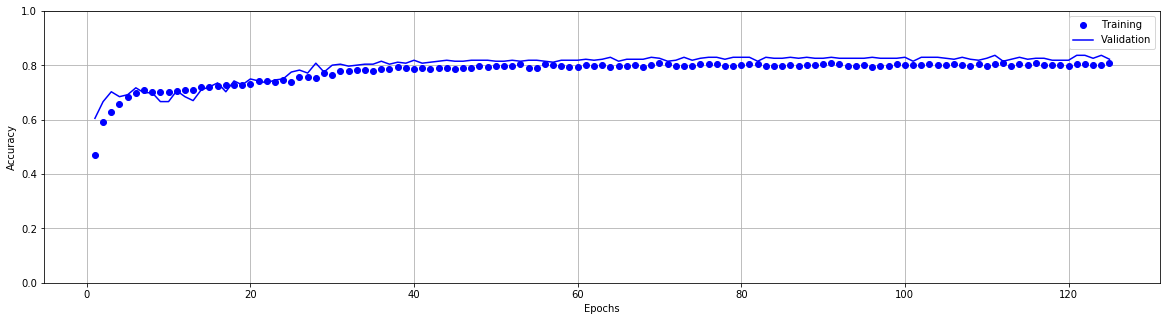

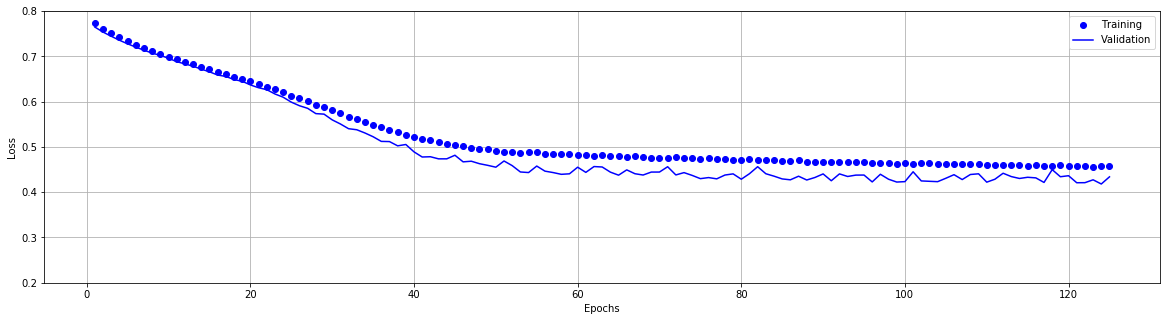

[0.43388372400532599, 0.82246376811594202]
Data with NaN-containing rows dropped


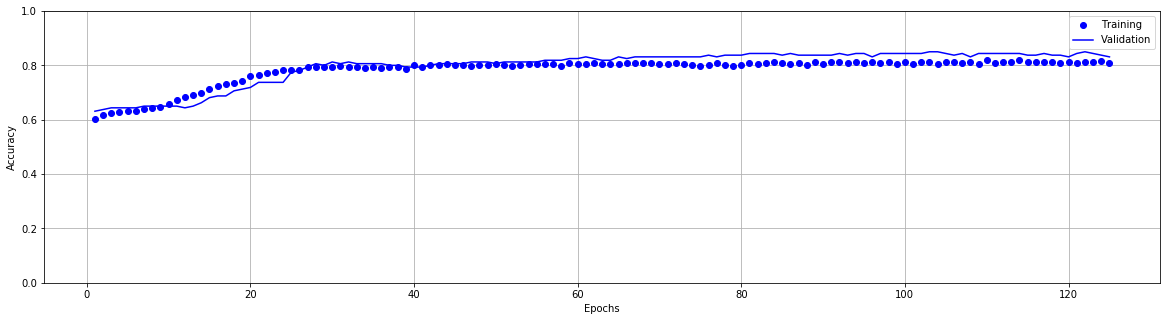

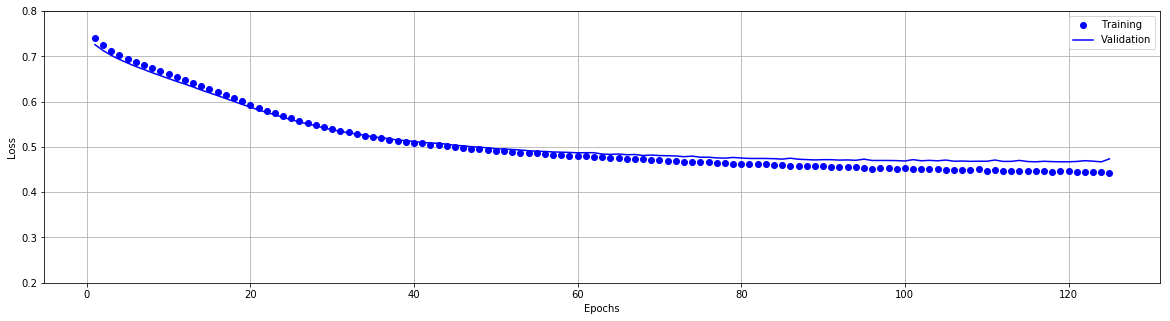

160/160 [==============================] - 0s 50us/step


[0.47363848686218263, 0.83125000000000004]

In [32]:

epochs = range(1, N + 1)
acc = h.history['acc']
val_acc = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']

acc2 = h2.history['acc']
val_acc2 = h2.history['val_acc']
loss2 = h2.history['loss']
val_loss2 = h2.history['val_loss']

# Mean-filled data
print("Data with NaN filled by mean")

# Accuracy plot
plt.figure(figsize = (20, 5))
plt.plot(epochs, acc, 'bo', label='Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize = (20, 5))
plt.plot(epochs, loss, 'bo', label='Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0.2, 0.8])
plt.grid()
plt.legend()
plt.show()

print(score)

# NaN-dropped data
print("Data with NaN-containing rows dropped")

# Accuracy plot
plt.figure(figsize = (20, 5))
plt.plot(epochs, acc2, 'bo', label='Training')
plt.plot(epochs, val_acc2, 'b', label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize = (20, 5))
plt.plot(epochs, loss2, 'bo', label='Training')
plt.plot(epochs, val_loss2, 'b', label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0.2, 0.8])
plt.grid()
plt.legend()
plt.show()


score2 = model.evaluate(x_test2, y_test2, batch_size = 128)
score2

## 7. Results and Discussion

I tweaked a bit of this and that in the hyperparameters but I still didn't get much above 80% accuracy. In the case of the dataset in which the rows with missing values were dropped, accuracy is about the same, despite the smaller sample size. I didn't get a lot of improvement in the accuracy even though I experimented with the following:
- Varying the amount of epochs
- Varying the batch size
- Varying the amount of layers
- Varying the amount of neurons in layers
- Adding a regularizer to counteract overfitting while the amount of epochs increased

Some improvement was made by adding more epochs and adding the regularizer, but final accuracy is still around 80-83%.<br><br>
<b>Later addition:</b><br>
After restarting the kernel and running all cells, my validation accuracy numbers started getting higher than the training accuracy. I'm not quite sure where this comes from. I don't think I changed anything in the code, just cleanup of comments and markdown cells.

## 8. Conclusions

Getting the accuracy to increase while keeping overfitting to a minimum, and doing all this with an effective and low-cost amount of computing time, is challenging. I suspect that in this case the small sample size is to blame for the somewhat poor accuracy. Ideally this kind of project would have sample sizes of millions, with all entries having all the data that correlates with the end result. By omitting the angiographic data columns in this case, we are omitting data that, if present, could prove to be a helpful addition to the set and could help with improving the accuracy. With that many missing values rendering the data practically unusable, we can't know for sure.<br><br>

Dropping all the rows from the dataset (where the angiographic columns were already removed) decreased the sample size further, but this proved to have a similar effect on accuracy as filling in the missing data with the mean value of the column.